Загрузка и обработка файлов

In [1]:
import os
import hashlib
from itertools import chain
import shutil
import csv
import cv2
import random

import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Получим список жанров

# Укажем путь к каталогу, в котором находятся подкаталоги
directory_to_check = 'data'

# Получаем список всех подкаталогов в указанном каталоге
genres = [name for name in os.listdir(directory_to_check) if os.path.isdir(os.path.join(directory_to_check, name))]

# Выводим список жанров
print("Список жанров:")
for genres in genres:
    print(genres)

Список жанров:
anime
black metal
classical
country
disco
edm
jazz
pop
rap
reggae


In [3]:
# Функция для поиска дубликатов файлов
def find_duplicate_files(directory):
    # Словарь для хранения хешей файлов
    files_hashes = {}
    # Словарь для хранения дубликатов файлов
    duplicates = {}

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Вычисляем хеш файла
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            # Проверяем наличие хеша в словаре
            if file_hash in files_hashes:
                # Если хеш уже есть, добавляем файл в список дубликатов
                if file_hash not in duplicates:
                    duplicates[file_hash] = []
                duplicates[file_hash].append(file_path)
            else:
                # Если хеша нет, добавляем его в словарь
                files_hashes[file_hash] = file_path

    # Удаляем из словаря дубликатов те файлы, которые находятся в разных каталогах
    for hash_value, file_paths in list(duplicates.items()):
        if len(set(os.path.dirname(file_path) for file_path in file_paths)) > 1:
            del duplicates[hash_value]

    return duplicates


# Поиск дубликатов файлов
duplicate_files = find_duplicate_files(directory_to_check)

# Проверка наличия дубликатов и вывод результата
if duplicate_files:
    print("Найдены дубликаты файлов:")
    for hash_value, file_paths in duplicate_files.items():
        print(f"Хеш: {hash_value}")
        for file_path in file_paths:
            print(f" - Файл: {file_path}")
    print(f"Всего найдено дубликатов: {sum(len(file_paths) for file_paths in duplicate_files.values())}")
else:
    print("Дубликаты файлов не найдены.")


Дубликаты файлов не найдены.


In [4]:
# Функция для удаления дубликатов из подкаталогов
def remove_duplicate_files(directory):
    files_hashes = {}

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Вычисляем хеш файла
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            # Проверяем наличие хеша в словаре с учетом пути к файлу
            if file_hash in files_hashes and files_hashes[file_hash] != file_path:
                # Если хеш уже есть и файл не находится в том же каталоге, удаляем файл
                print(f"Удаляем дубликат файла: {file_path}")
                os.remove(file_path)
            else:
                # Если хеша нет или файл находится в том же каталоге, добавляем его в словарь
                files_hashes[file_hash] = file_path

# Удаление дубликатов файлов
remove_duplicate_files(directory_to_check)

In [5]:
# Создаем словарь, в котором ключами являются названия подкаталогов,
# а значениями - списки файлов, находящихся в этих подкаталогах. 
# Каждый файл представлен своим полным путем.

def create_directory_file_map(directory):
    file_to_label = {}

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            directory_name = os.path.basename(root)
            if directory_name != os.path.basename(directory):
                if directory_name not in file_to_label:
                    file_to_label[directory_name] = []
                file_to_label[directory_name].append(file_path)

    return file_to_label

# Создание словаря
file_to_label = create_directory_file_map(directory_to_check)

In [6]:
# Сохраним этот словарь на диск

# Убедимся, что каталог существует
if not os.path.exists(directory_to_check):
    os.makedirs(directory_to_check)

# Полный путь к файлу
file_path = os.path.join(directory_to_check, "file_to_label.json")

# Запись словаря в JSON файл
with open(file_path, 'w') as file:
    json.dump(file_to_label, file)

print(f"Словарь успешно сохранен в {file_path}")

Словарь успешно сохранен в data\file_to_label.json


In [7]:
# Вывод всех ключей и по 1 значению для каждого ключа
for key, values in file_to_label.items():
    print(f"Ключ: {key}")
    print(f"Значение(я): {values[0]}")
    print(f"Количество обложек: {len(values)}")
    print('***')
    # print()

Ключ: anime
Значение(я): data\anime\00095702-6b86-4bb1-880e-1e09e759a013.png
Количество обложек: 1184
***
Ключ: black metal
Значение(я): data\black metal\0045bdd1-6829-4ecc-82ea-99a9958d5fcb.png
Количество обложек: 449
***
Ключ: classical
Значение(я): data\classical\0049cfb2-17e7-4316-b60c-4499df770492.png
Количество обложек: 951
***
Ключ: country
Значение(я): data\country\002b7538-2c76-46f0-b4f4-896002222dae.png
Количество обложек: 1483
***
Ключ: disco
Значение(я): data\disco\00af76c0-0e01-4545-b050-8b548bc95d56.png
Количество обложек: 466
***
Ключ: edm
Значение(я): data\edm\00024487-47fe-46be-8820-e772c93966b4.png
Количество обложек: 702
***
Ключ: jazz
Значение(я): data\jazz\003dad6c-43d5-39ea-8d23-009d3eca6920.png
Количество обложек: 819
***
Ключ: pop
Значение(я): data\pop\00f71d58-7ab6-4b09-9bc0-aa5e44f74f7a.png
Количество обложек: 790
***
Ключ: rap
Значение(я): data\rap\006bb981-d9e6-4ccb-93d2-33e061f8b376.png
Количество обложек: 326
***
Ключ: reggae
Значение(я): data\reggae\0086f

In [8]:
# Подсчет общего количества значений
total_values = sum(len(files) for files in file_to_label.values())

print(f"Общее количество обложек для анализа: {total_values}")

Общее количество обложек для анализа: 7748


In [13]:

# Переменные для подсчета количества пустых и не пустых изображений
empty_images_count = 0
non_empty_images_count = 0

# Пройдем по каждому жанру в словаре file_to_label
for genre, file_list in file_to_label.items():
    # Пройдем по каждому пути к файлу в списке файлов для данного жанра
    for sample_path in file_list:
        try:
            img = Image.open(sample_path)
            # Проверяем размер изображения
            if img.size == (0, 0):
                empty_images_count += 1
            else:
                non_empty_images_count += 1
        except Exception as e:
            print(f"Ошибка открытия изображения: {e}")
            continue

# Выведем общее количество пустых и не пустых изображений
print(f"Количество пустых изображений: {empty_images_count}")
print(f"Количество не пустых изображений: {non_empty_images_count}")


Количество пустых изображений: 0
Количество не пустых изображений: 7748


Жанр: anime
Путь к изображению: data\anime\fad52a20-402c-4b52-919b-b102db79a800.png


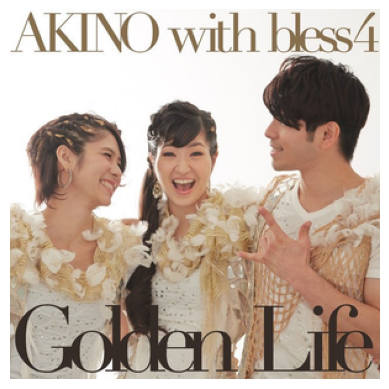


Жанр: black metal
Путь к изображению: data\black metal\48c5e30b-3e65-44c1-93a9-8e6d2f04e3d6.png


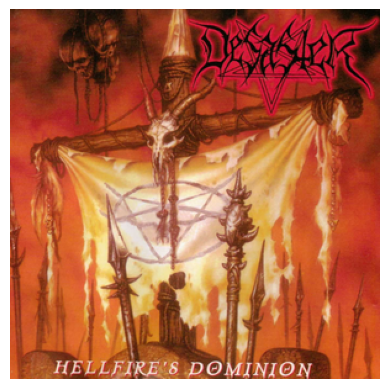


Жанр: classical
Путь к изображению: data\classical\cc3e3381-c7fe-4a52-8367-2af316bdf669.png


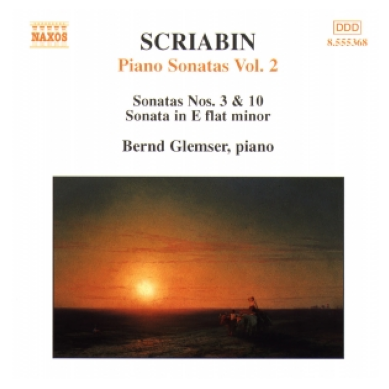


Жанр: country
Путь к изображению: data\country\3ddced0c-1256-4934-9a9e-c46f57bafe1c.png


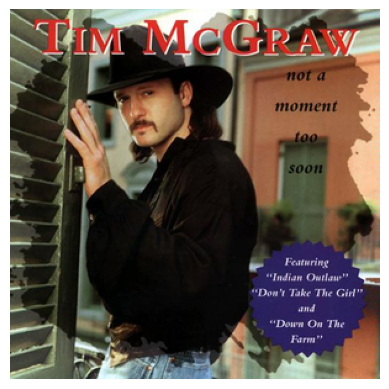


Жанр: disco
Путь к изображению: data\disco\9419f0b4-8be6-4c43-ade1-56e6cd55910c.png


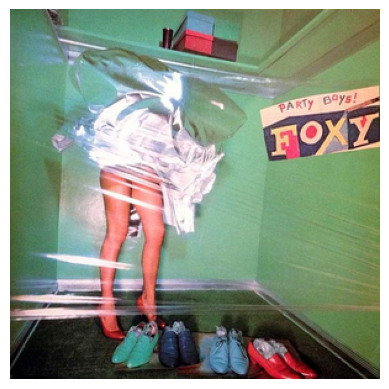


Жанр: edm
Путь к изображению: data\edm\a3502abd-2a4b-4f32-b85f-209952c436e3.png


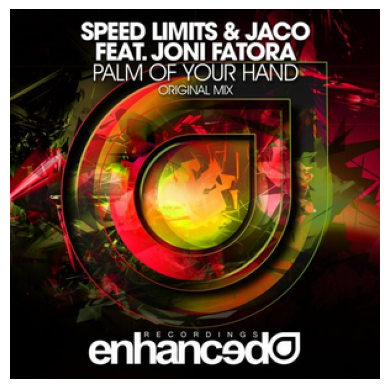


Жанр: jazz
Путь к изображению: data\jazz\958960c7-5dd8-4a87-a6bd-5b4efcbdb5e2.png


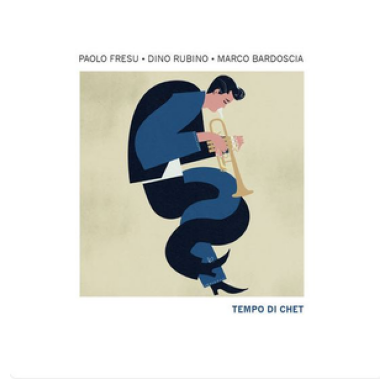


Жанр: pop
Путь к изображению: data\pop\8500ffd2-d950-4e1a-bf10-fd60934528a8.png


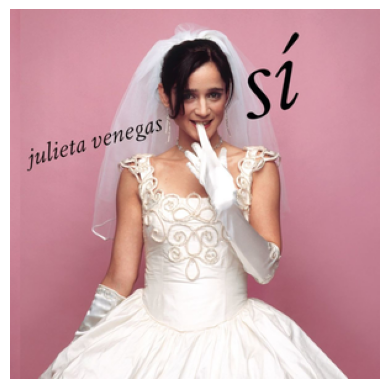


Жанр: rap
Путь к изображению: data\rap\996e3499-9459-4523-addd-9b53d540ce9e.png


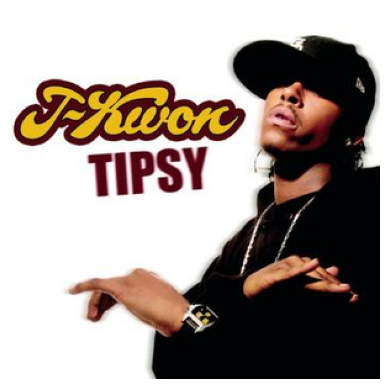


Жанр: reggae
Путь к изображению: data\reggae\62f142ac-5342-4586-8c1f-3a0079df3023.png


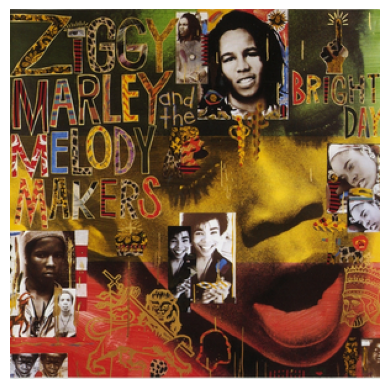

In [9]:
# Функция для выбора случайного образца файла из списка файлов
def choose_random_sample(files_list):
    return random.choice(files_list) if files_list else None

# Создадим список для хранения случайных образцов изображений для каждого жанра
random_samples = []

# Пройдем по каждому жанру в словаре file_to_label
for genre, file_list in file_to_label.items():
    # Выберем случайное изображение из списка файлов для текущего жанра
    random_sample = choose_random_sample(file_list)
    # Добавим случайное изображение в список случайных образцов
    random_samples.append(random_sample)

# Выведем изображения
for genre, sample_path in zip(file_to_label.keys(), random_samples):
    print(f"Жанр: {genre}")
    if sample_path:
        print(f"Путь к изображению: {sample_path}")
        try:
            img = Image.open(sample_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Ошибка открытия изображения: {e}")
            continue
    else:
        print("Изображение не найдено.")
    print()


In [10]:
# Разделим данные для каждого класса отдельно, учитывая их пропорции.

# Создаем пустые списки для обучающих и тестовых данных
train_image_paths = []
test_image_paths = []
train_labels = []
test_labels = []

# Проходим по каждому классу в словаре file_to_label
for label, image_paths in file_to_label.items():
    # Разделяем пути к файлам для каждого класса
    train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
    
    # Добавляем разделенные пути к файлам в соответствующие списки
    train_image_paths.extend(train_paths)
    test_image_paths.extend(test_paths)
    
    # Добавляем метку класса для каждого соответствующего пути к файлу
    train_labels.extend([label] * len(train_paths))
    test_labels.extend([label] * len(test_paths))

# Выводим размеры обучающей и тестовой выборок
print("Размер обучающей выборки:", len(train_image_paths))
print("Размер тестовой выборки:", len(test_image_paths))


Размер обучающей выборки: 6194
Размер тестовой выборки: 1554


In [11]:
# создаем файлы CSV train_data.csv и test_data.csv 
# и записываем в них данные из списков train_data и test_data. 
# Каждая строка в файле CSV будет содержать путь к изображению 
# и соответствующую метку

# Задаем имена файлов CSV для обучающих и тестовых данных
train_csv_file = "train_data.csv"
test_csv_file = "test_data.csv"

# Собираем данные в списки списков для записи в CSV
train_data = list(zip(train_image_paths, train_labels))
test_data = list(zip(test_image_paths, test_labels))

# Функция для записи данных в файл CSV
def write_data_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_path', 'label'])  # Записываем заголовки столбцов
        writer.writerows(data)

# Записываем данные в файлы CSV
write_data_to_csv(train_data, train_csv_file)
write_data_to_csv(test_data, test_csv_file)

print("Данные успешно записаны в файлы CSV:", train_csv_file, "и", test_csv_file)

Данные успешно записаны в файлы CSV: train_data.csv и test_data.csv


In [12]:
# Проверим размер изображений
def get_image_sizes(image_paths):
    image_sizes = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is not None:
            height, width, _ = image.shape
            image_sizes.append((height, width))
    return image_sizes

# Пример использования:
# Предположим, что у вас есть список image_paths, содержащий пути к изображениям
# image_paths = [...] 
image_sizes = get_image_sizes(test_image_paths)

# Вывод уникальных размеров изображений
unique_sizes = np.unique(image_sizes, axis=0)
print("Уникальные размеры изображений:")
for size in unique_sizes:
    print(f"Высота: {size[0]}, Ширина: {size[1]}")

Уникальные размеры изображений:
Высота: 300, Ширина: 300


## Вывод по этапу.   
Посмотрели данные, удалили дубликаты.  
Общее количество обложек для анализа: 7748  
Создали словарь, в которм ключи - это жанры, значения - пути к файлам обложек.  
Разделили выборку на тренировочную и тестовую в пропорции 80 к 20.  
При необходимости можем разделить данные на тренировочные и тестовые по отдельным подкаталогам. 
Пока не знаю, есть ли такая необходимость.  